## 1. Get the data ready
This will use Fasion MNIST dataset 

In [2]:
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [13]:
from torch.utils.data import DataLoader
data_root = './data'

class FashionMNIST():
    def __init__(self, resize = (28,28), batch_size = 512  ):
        self.batch_size = batch_size
        self.resize = resize
        trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5) ,(0.5))
                                ])

        self.train = torchvision.datasets.FashionMNIST(
            root=data_root,
            train= True, 
            transform= trans, 
            download= True)

        self.test = torchvision.datasets.FashionMNIST(
            root=data_root, 
            train=False, 
            transform= trans, 
            download=True)

        self.labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        
    def get_dataloader(self, train):
        data = self.train if train else self.test
        return DataLoader(data, self.batch_size, shuffle=train)
    
    def text_labels(self, indices):
        """Return text labels."""
        return [self.labels[int(i)] for i in indices]
            
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.test)

(60000, 10000)

torch.Size([512, 1, 32, 32]) torch.float32 torch.Size([512]) torch.int64


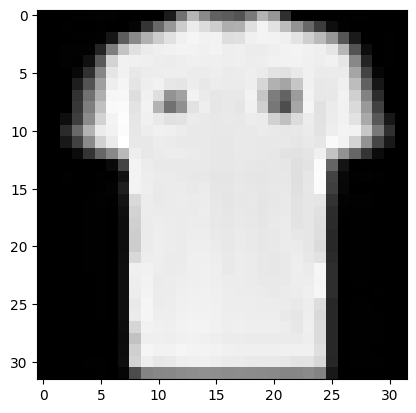

Label: ['t-shirt']


In [14]:
X, y = next(iter(data.get_dataloader(train=True)))
print(X.shape, X.dtype, y.shape, y.dtype)

img = X[0].squeeze()
label = y[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {data.text_labels([label])}")

Letsgoo we have data here 

Now let's work on the model but i'll do it from scratch first

1. Softmax 

$$
\textrm{where}\quad \hat{y}_i = \frac{\exp(X_{ij})}{\sum_j \exp(X_{ik})}.
$$

we need to compute the sum over the rows of each component not the columns for the denominator.

In [15]:
def softmax(X):
    # Subtract the max for numerical stability
    # keepdim=True allows broadcasting the subtraction
    X_shifted = X - X.max(axis=1, keepdim=True).values
    
    X_exp = torch.exp(X_shifted)
    denom = X_exp.sum(dim=1, keepdim=True)
    return X_exp / denom
    
    

In [16]:
# Check that softmax is working
X = torch.rand((2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1), X.sum(1)

(tensor([[0.3682, 0.6015, 0.7052, 0.4317, 0.9789],
         [0.9930, 0.1588, 0.5387, 0.0768, 0.9897]]),
 tensor([[0.1522, 0.1922, 0.2132, 0.1622, 0.2803],
         [0.2885, 0.1253, 0.1832, 0.1154, 0.2876]]),
 tensor([1.0000, 1.0000]),
 tensor([3.0854, 2.7570]))

2. The Model
This will be a one layer model with Weights of shape (IN, OUT)
and biases of shape (OUT)

$$\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$


In [17]:
class FashionMNISTModelScratch():
    def __init__(self, in_count, out_count, lr,):
        self.W = torch.normal(0, 0.01, size=(in_count, out_count), requires_grad=True, device=device)
        self.b = torch.zeros(out_count, requires_grad=True, device=device)
        self.lr = lr
        
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        # This should return the logits? or the probabilites? Yes Logits
        X = X.reshape((-1, self.W.shape[0]))
        return torch.matmul(X, self.W) + self.b

    def predict(self, X):
        logits = self.forward(X)
        return softmax(logits)

data = FashionMNIST()
model_0 = FashionMNISTModelScratch(in_count = data.resize[0] * data.resize[1],
                                   out_count= len(data.labels),
                                   lr = 0.01)

3. Cross entropy 

$$l(y,\hat{y}) = - \sum_{j=1}^q y_j \log \hat{y}_j$$

the cross entropy using minibatcehs is the average of this formula over the size of the minibatch

$$L = -\frac{1}{n} \sum_{j=1}^q y_j \log \hat{y}_j$$

In [18]:
def cross_entropy (y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y], cross_entropy(y_hat, y)

(tensor([0.1000, 0.5000]), tensor(1.4979))

In [19]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

optimizer = SGD(model_0.parameters(), model_0.lr)

In [20]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    return float((y_hat == y).sum())

# Evaluate on test set
def evaluate_accuracy(model, data_iter):
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = model.predict(X)
            correct += accuracy(y_hat, y)
            total += y.numel()
    return correct / total

In [21]:
epochs = 20
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_loader = data.get_dataloader(train=False)
train_loader = data.get_dataloader(train=True)

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    for X, y in  train_loader:
        X, y = X.to(device), y.to(device)

        y_hat = model_0.predict(X)
        loss = cross_entropy(y_hat, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        correct += accuracy(y_hat, y)
        total += y.numel()
    
    avg_loss = total_loss / len(data.get_dataloader(train=True))
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    
    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            y_hat = model_0.predict(X)
            loss = cross_entropy(y_hat, y)
            
            test_loss_sum += loss.item()
            test_correct += accuracy(y_hat, y)
            test_total += y.numel()
            
    # Calculate Test Averages
    avg_test_loss = test_loss_sum / len(test_loader)
    avg_test_acc = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accs.append(avg_test_acc)
    
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} Acc: {avg_test_acc:.4f}")

Epoch 1 | Train Loss: 1.0946 Acc: 0.6872 | Test Loss: 0.8101 Acc: 0.7399
Epoch 2 | Train Loss: 0.7310 Acc: 0.7628 | Test Loss: 0.7001 Acc: 0.7646
Epoch 3 | Train Loss: 0.6561 Acc: 0.7824 | Test Loss: 0.6497 Acc: 0.7791
Epoch 4 | Train Loss: 0.6168 Acc: 0.7940 | Test Loss: 0.6196 Acc: 0.7879
Epoch 5 | Train Loss: 0.5891 Acc: 0.8019 | Test Loss: 0.5987 Acc: 0.7928
Epoch 6 | Train Loss: 0.5701 Acc: 0.8083 | Test Loss: 0.5817 Acc: 0.7984
Epoch 7 | Train Loss: 0.5545 Acc: 0.8122 | Test Loss: 0.5697 Acc: 0.8034
Epoch 8 | Train Loss: 0.5434 Acc: 0.8157 | Test Loss: 0.5602 Acc: 0.8034
Epoch 9 | Train Loss: 0.5330 Acc: 0.8189 | Test Loss: 0.5513 Acc: 0.8077
Epoch 10 | Train Loss: 0.5251 Acc: 0.8214 | Test Loss: 0.5441 Acc: 0.8089
Epoch 11 | Train Loss: 0.5188 Acc: 0.8236 | Test Loss: 0.5407 Acc: 0.8108
Epoch 12 | Train Loss: 0.5133 Acc: 0.8260 | Test Loss: 0.5330 Acc: 0.8135
Epoch 13 | Train Loss: 0.5066 Acc: 0.8278 | Test Loss: 0.5287 Acc: 0.8169
Epoch 14 | Train Loss: 0.5024 Acc: 0.8294 | Tes

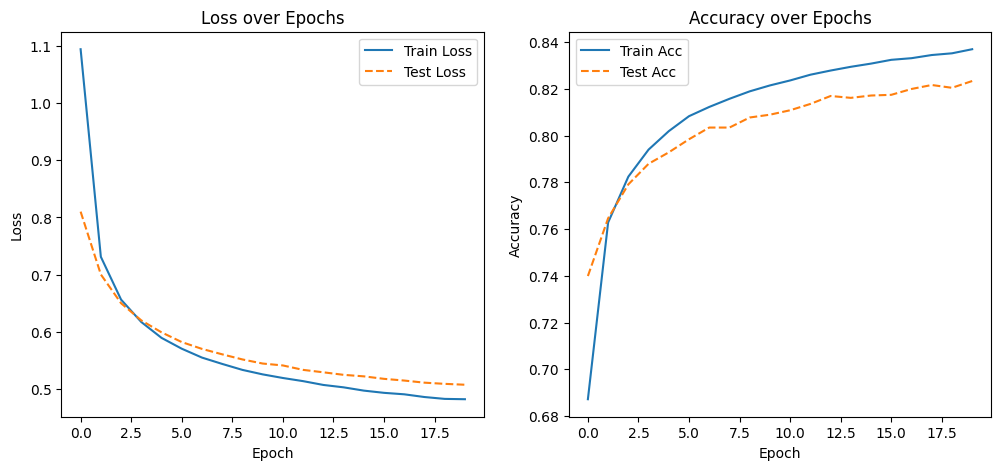

In [22]:
# --- PLOTTING THE RESULTS ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [24]:
from pathlib import Path

CURRENT_DIR = Path().resolve()

MODEL_PATH = CURRENT_DIR /"classification"/ "models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "fashion_MNIST_scratch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(MODEL_SAVE_PATH)

torch.save({
    "W": model_0.W,
    "b": model_0.b
},MODEL_SAVE_PATH)

/home/eren/Coding/ML_DL_notes/classification/models/fashion_MNIST_scratch.pth
